In [7]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


from PIL import Image
import matplotlib.pyplot as plt

from collections import Counter


# Load Dataset

In [8]:
CSV_FILE_NAME = './data/my_file.csv'
arr = pd.read_csv(CSV_FILE_NAME, header=None)

In [9]:
# X, y_class, y_reg = arr.iloc[:, :-5].values, arr.iloc[:, -5:-4].values, arr.iloc[:, -4:].values
X, y = arr.iloc[:, :-5].values, arr.iloc[:, -5:].values
X = X.reshape(-1, 200, 200, 1)


# one hot encoding
# y_class = tf.keras.utils.to_categorical(y_class, num_classes=17)

# dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_class_test, y_reg_test = y_test[:, -5:-4], y_test[:, -4:]
y_class_train, y_reg_train = y_train[:, -5:-4], y_train[:, -4:]
y_class_test = tf.keras.utils.to_categorical(y_class_test, num_classes=17)
y_class_train = tf.keras.utils.to_categorical(y_class_train, num_classes=17)
# y_class_train = y_class_train +1
# y_class_test = y_class_test +1

# if no data augmentation
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_class_train.argmax(axis=1)),
                                                  y=y_class_train.argmax(axis=1))

class_weights_dict = dict(enumerate(class_weights))


In [10]:
print(y_train.shape, y_test.shape)

(519, 5) (130, 5)


# Model

In [11]:
seqmodel = models.Sequential([
    layers.Input(shape=(200, 200, 1)),
    # layers.Dense(40000),
    # layers.Input(shape=(400, 400, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    # layers.Conv2D(32, 3, kernel_regularizer=l2(0.0001), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    # layers.Conv2D(64, 3, kernel_regularizer=l2(0.0001), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
])

#change from sequential to functional to enable branches
input_layer = layers.Input((200,200,1))
prev_layer = input_layer
for layer in seqmodel.layers:
    prev_layer = layer(prev_layer)


outputClass = layers.Dense(17, activation="sigmoid", name="CatOut")(prev_layer)
outputReg = layers.Dense(4, activation="softmax", name ="RegOut")(prev_layer)

#Combine
funcmodel = models.Model(inputs=input_layer, outputs=[outputClass, outputReg])
# funcmodel = models.Model([input_layer], [prev_layer])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

# f1_metric = tf.metrics.F1Score(average='macro')
# f1_metric = tf.metrics.F1Score(average='weighted') # if no data augmentation
# mse_metric = tf.metrics.Mean


funcmodel.compile(optimizer=Adam(0.001),
              loss= {'CatOut': 'categorical_crossentropy', 'RegOut': 'mse'},
              metrics={'CatOut': tf.metrics.CategoricalAccuracy(name='acc'), 'RegOut': 'accuracy'},
              )


funcmodel.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 198, 198,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 99, 99,    │          0 │ conv2d_2[1][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 97, 97,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 48, 48,    │          0 │ conv2d_3[1][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 147456)    │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 147456)    │          0 │ flatten_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  9,437,248 │ dropout_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CatOut (Dense)      │ (None, 17)        │      1,105 │ dropout_3[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RegOut (Dense)      │ (None, 4)         │        260 │ dropout_3[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,457,429 (36.08 MB)

 Trainable params: 9,457,429 (36.08 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = funcmodel.fit(X_train, {'CatOut': y_class_train, 'RegOut': y_reg_train}, epochs=50, validation_data=(X_test, {'CatOut': y_class_test, 'RegOut': y_reg_test}))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 597ms/step - CatOut_acc: 0.0791 - RegOut_accuracy: 0.3887 - loss: 3.7639 - val_CatOut_acc: 0.0692 - val_RegOut_accuracy: 0.4385 - val_loss: 2.8892
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 554ms/step - CatOut_acc: 0.0687 - RegOut_accuracy: 0.4996 - loss: 2.8829 - val_CatOut_acc: 0.0538 - val_RegOut_accuracy: 0.3615 - val_loss: 2.8943
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - CatOut_acc: 0.1113 - RegOut_accuracy: 0.4779 - loss: 2.8319 - val_CatOut_acc: 0.0385 - val_RegOut_accuracy: 0.6538 - val_loss: 2.8913
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 609ms/step - CatOut_acc: 0.1827 - RegOut_accuracy: 0.5711 - loss: 2.6244 - val_CatOut_acc: 0.1000 - val_RegOut_accuracy: 0.5385 - val_loss: 2.8230
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 541ms/step - CatOut_acc: 0.2940 - RegOut_accuracy: 0.4964 - loss: 2.2887 - val_CatOut_acc: 0.1154 - val_RegOut_accuracy: 0.5308 - val_loss: 2.8934
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step - Ca

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

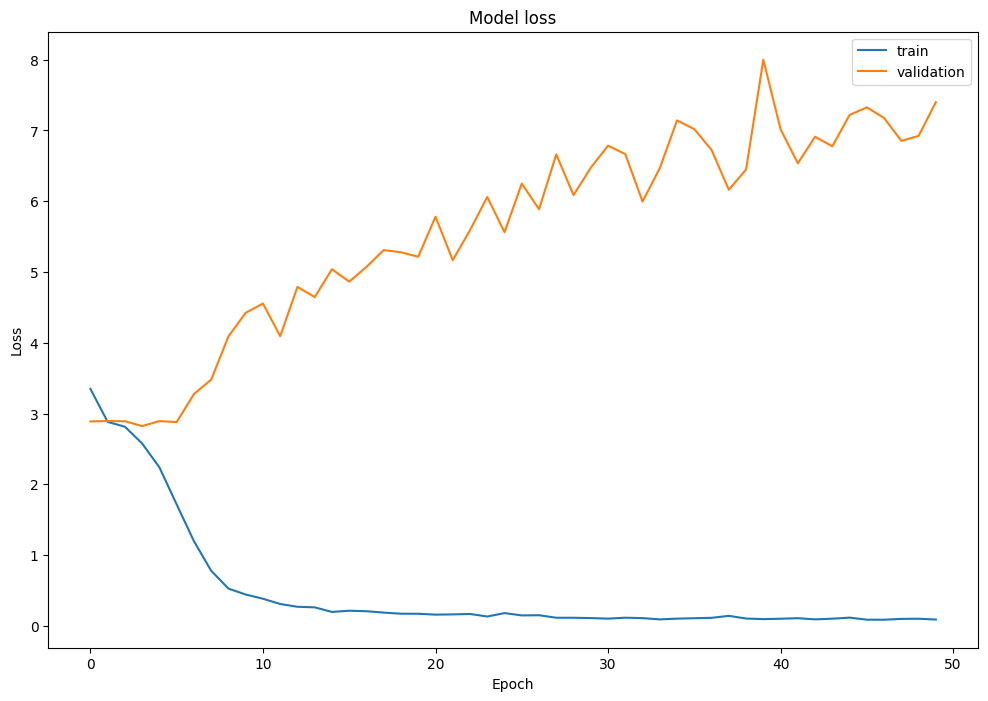

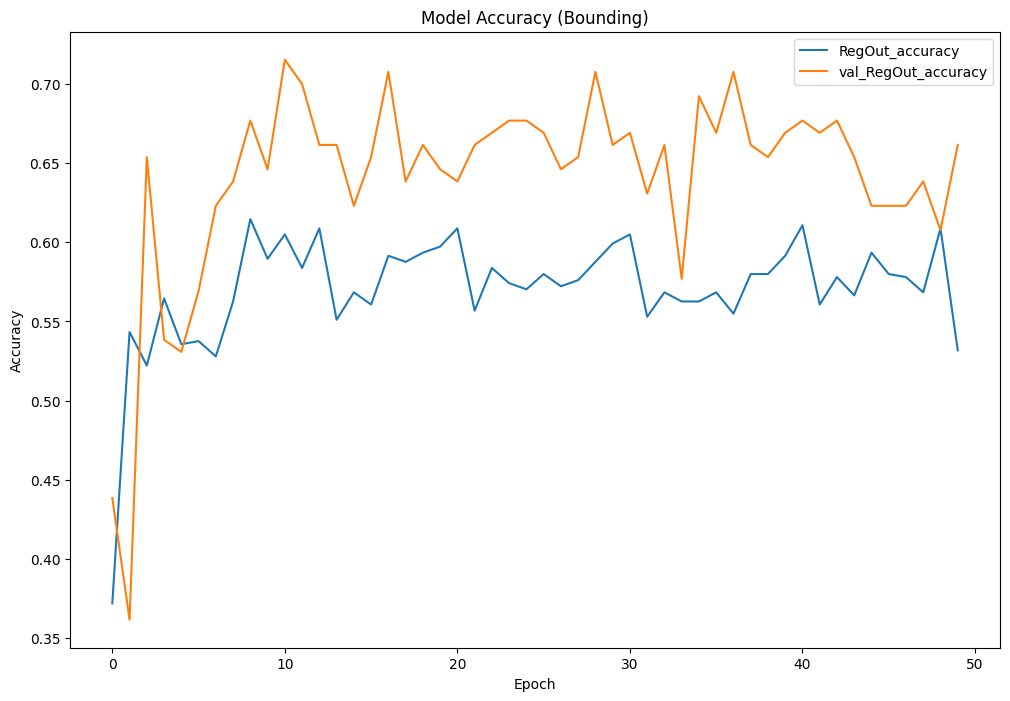

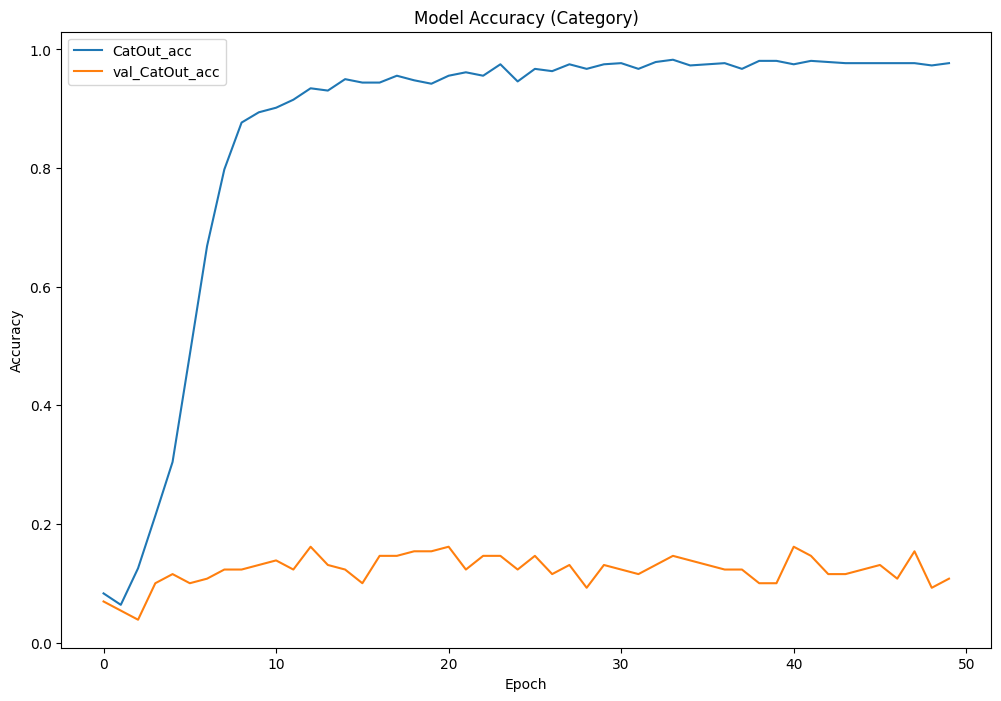

In [13]:
# Convert model history dictionary to DataFrame
df_loss_acc = pd.DataFrame(funcmodel.history.history)

# Select loss columns and rename
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

# Select accuracy columns and rename
df_acc = df_loss_acc[['RegOut_accuracy', 'val_RegOut_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Select accuracy columns and rename
df_acc2 = df_loss_acc[['CatOut_acc', 'val_CatOut_acc']].copy()
df_acc2.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Plot model loss
df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plot model accuracy
df_acc.plot(title='Model Accuracy (Bounding)', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')

# Plot model accuracy
df_acc2.plot(title='Model Accuracy (Category)', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')


In [14]:
result = funcmodel.evaluate(X_test, y_test_reg)
print("Result:", result)

NameError: name 'y_test_reg' is not defined